In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive') # Uncomment when running the notebook for first time
os.chdir("/content/drive/MyDrive/SurgTools")
os.getcwd()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/SurgTools'

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision
from torchvision import transforms as T
from torchvision import utils
import xml.etree.ElementTree as ET
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import default_collate
from tqdm import tqdm
import numpy as np

In [ ]:
# Parse XML files
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    objects = []
    for obj in root.iter('object'):
        obj_dict = {
            'name': obj.find('name').text,
            'bbox': [
                int(obj.find('bndbox/xmin').text),
                int(obj.find('bndbox/ymin').text),
                int(obj.find('bndbox/xmax').text),
                int(obj.find('bndbox/ymax').text)
            ]
        }
        objects.append(obj_dict)
    return objects

In [ ]:
def convert_to_coco_targets(labels):
  tools = []
  bboxes = []

  for label in labels:
    tools.append(label['labels'])
    bboxes.append(label['boxes'])

  targets = (tuple(tools), tuple(bboxes))
  return targets

In [ ]:
your_label_map = {
    "Grasper": 1,
    "Bipolar": 2,
    "Hook": 3,
    "Scissors": 4,
    "Clipper": 5,
    "Irrigator": 6,
    "SpecimenBag": 7
}


def resize_bbox(bbox, in_size, out_size):
    """
    Adjust bounding box size.
    :param bbox: Original bounding box coordinates in the format [xmin, ymin, xmax, ymax]
    :param in_size: original image size (width, height)
    :param out_size: new image size (width, height)
    :return: adjusted bounding box coordinates
    """
    xmin, ymin, xmax, ymax = bbox
    scale_x = out_size[0] / in_size[0]
    scale_y = out_size[1] / in_size[1]
    xmin = int(xmin * scale_x)
    ymin = int(ymin * scale_y)
    xmax = int(xmax * scale_x)
    ymax = int(ymax * scale_y)
    return [xmin, ymin, xmax, ymax]

class CustomDataset(Dataset):
    def __init__(self, imgs_dir, anns_dir, transforms=None):
        self.imgs_dir = imgs_dir
        self.anns_dir = anns_dir
        self.transforms = transforms

        # Get the names of all image and annotation files, with extensions removed
        anns = set(os.path.splitext(file)[0] for file in os.listdir(anns_dir))
        imgs = anns

        # Keep image file names with matching annotations
        self.imgs = [file + '.jpg' for file in imgs]  # Assuming the image file is in .jpg format
        self.annotations = [file + '.xml' for file in anns]  # Assume that the annotation file is in .xml format

        # Make sure the image and annotation file lists are of equal length
        assert len(self.imgs) == len(self.annotations), "Images and annotations lists are not the same length"

    def __getitem__(self, idx):
        # print("getting")
        img_path = os.path.join(self.imgs_dir, self.imgs[idx])
        ann_path = os.path.join(self.anns_dir, self.annotations[idx])

        # read images
        image = Image.open(img_path).convert("RGB")
        original_size = image.size
        new_size = (480, 480)

        # Parse XML files using parse_xml function
        objects = parse_xml(ann_path)


        boxes = []
        labels = []
        num_objs = len(objects)
        for obj in objects:
            label_name = obj['name']
            label = your_label_map[label_name]  # Convert category name to integer
            labels.append(label)

            # Add bounding box coordinates
            bbox = obj['bbox']
            resized_bbox = resize_bbox(bbox, original_size, new_size)
            boxes.append(resized_bbox)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)


        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        # target["image_id"] = idx
        # target["area"] = area
        # target["iscrowd"] = iscrowd

        if self.transforms is not None:
            image = self.transforms(image)  # Apply conversion to image
            # If necessary, you can also convert the target accordingly
            # For example, if random flipping is used, the bounding box of the target needs to be adjusted accordingly

        return image, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
from torchvision.transforms import functional as F


# imgs_dir = "/content/m2cai16-tool-locations/JPEGImages"
# anns_dir = "/content/m2cai16-tool-locations/Annotations"

imgs_dir = "./m2cai16-tool-locations/JPEGImages/"
anns_dir = "./m2cai16-tool-locations/Annotations/"

def get_transform(train):
    transforms = []
    # Convert PIL image to PyTorch Tensor
    transforms.append(T.ToTensor())
    # if train:
    #     # Data augmentation during training phase, such as random horizontal flipping
    #     transforms.append(T.RandomHorizontalFlip(0.5))
    #     # More data enhancement operations can be added, such as:
    #     # transforms.append(T.RandomVerticalFlip(0.5))
    #     # transforms.append(T.ColorJitter(...))
    transforms.append(T.Resize((480, 480), antialias=None))  # 以 600x600 为例
    return T.Compose(transforms)


def collate_fn(batch):
    # Stack or pack images and targets separately, because images have different numbers of boxes
    images = [item[0] for item in batch]
    targets = [(item[1]) for item in batch]

    images = default_collate(images)  # Use default stacking method for images
    # Targets do not need to be stacked as they may be of different lengths
    targets = convert_to_coco_targets(targets)
    return images, targets


# Create a dataset instance
dataset = CustomDataset(imgs_dir, anns_dir, transforms=get_transform(True))
# data_loader = DataLoader(dataset, batch_size=10, shuffle=True, num_workers=4, collate_fn=collate_fn)

generator2 = torch.Generator()#.manual_seed(42)
split_data = torch.utils.data.random_split(dataset, [0.7, 0.2, 0.1], generator=generator2)
train_dataset = split_data[0]
val_dataset = split_data[1]
test_dataset = split_data[2]

# len(train_dataset), len(val_dataset), len(test_dataset)

batchsize = 16
learnrate = 0.002

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, collate_fn=collate_fn)
val_datalaoder = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=2, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=2, collate_fn=collate_fn)

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW, lr_scheduler
import torchvision.transforms as T
from torchvision import datasets, ops
from torchvision.models.feature_extraction import create_feature_extractor
from einops import rearrange

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import linear_sum_assignment

In [ ]:
CLASSES = [
    'Grasper', 'Bipolar', 'Hook', 'Scissors', 'Clipper', 'Irrigator',
    'SpecimenBag', 'empty'
]

# Colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098],
          [0.929, 0.694, 0.125], [0.494, 0.184, 0.556],
          [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]
COLORS *= 100

revert_normalization = T.Normalize(
    mean=[-.485/.229, -.456/.224, -.406/.225],
    std=[1/.229, 1/.224, 1/.225]
)

def plot_im_with_boxes(im, boxes, probs=None, ax=None):

    if ax is None:
        plt.imshow(im)
        ax = plt.gca()

    for i, b in enumerate(boxes.tolist()):
        xmin, ymin, xmax, ymax = b

        patch = plt.Rectangle(
            (xmin, ymin), xmax - xmin, ymax - ymin,
            fill=False, color=COLORS[i], linewidth=2)

        ax.add_patch(patch)
        if probs is not None:
            if probs.ndim == 1:
                cl = probs[i].item()
                text = f'{CLASSES[cl]}'
            else:
                cl = probs[i].argmax().item()
                text = f'{CLASSES[cl]}: {probs[i,cl]:0.2f}'
        else:
            text = ''

        ax.text(xmin, ymin, text, fontsize=7,
                bbox=dict(facecolor='yellow', alpha=0.5))


def preprocess_target(anno, im_w, im_h):

    anno = [obj for obj in anno
            if 'iscrowd' not in obj or obj['iscrowd'] == 0]

    boxes = [obj["bbox"] for obj in anno]
    boxes = torch.as_tensor(
        boxes, dtype=torch.float32).reshape(-1, 4)

    # xywh -> xyxy
    boxes[:, 2:] += boxes[:, :2]
    boxes[:, 0::2].clamp_(min=0, max=im_w)
    boxes[:, 1::2].clamp_(min=0, max=im_h)
    keep = (boxes[:, 3] > boxes[:, 1]) & (boxes[:, 2] > boxes[:, 0])
    boxes = boxes[keep]

    classes = [obj["category_id"] for obj in anno]
    classes = torch.tensor(classes, dtype=torch.int64)
    classes = classes[keep]

    # scales boxes to [0,1]
    boxes[:, 0::2] /= im_w
    boxes[:, 1::2] /= im_h
    boxes.clamp_(min=0, max=1)

    boxes = ops.box_convert(boxes, in_fmt='xyxy', out_fmt='cxcywh')
    return classes, boxes

In [ ]:
def get_hook(outs, name):
    def hook(self, input, output):
        outs[name] = output
    return hook

In [ ]:
class DETR(nn.Module):

    def __init__(
        self, d_model=256, n_classes=8, n_tokens=225,
        n_layers=6, n_heads=8, n_queries=100
    ):
        super().__init__()

        self.backbone = create_feature_extractor(
            torch.hub.load('pytorch/vision:v0.10.0',
                           'resnet50', pretrained=True),
            return_nodes={'layer4': 'layer4'}
        )

        self.conv1x1 = nn.Conv2d(
            2048, d_model, kernel_size=1, stride=1)

        self.pe_encoder = nn.Parameter(
            torch.rand((n_tokens, d_model)),
            requires_grad=True)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads,
            dim_feedforward=4*d_model, dropout=0.1)

        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, num_layers=n_layers)

        self.queries = nn.Parameter(
            torch.rand((n_queries, d_model)),
            requires_grad=True)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model, nhead=n_heads,
            dim_feedforward=4*d_model,
            batch_first=True, dropout=0.1)

        self.transformer_decoder = nn.TransformerDecoder(
            decoder_layer, num_layers=n_layers)

        self.linear_class = nn.Linear(d_model, n_classes)
        self.linear_bbox = nn.Linear(d_model, 4)

        # Add hooks to get intermediate outcomes
        self.decoder_outs = {}
        for i, L in enumerate(self.transformer_decoder.layers):
            name = f'layer_{i}'
            L.register_forward_hook(
                get_hook(self.decoder_outs, name))


    def forward(self, x):
        tokens = self.backbone(x)['layer4']
        tokens = self.conv1x1(tokens)
        tokens = rearrange(tokens, 'b c h w -> b (h w) c')

        tokens.shape, self.pe_encoder.shape
        out_encoder = self.transformer_encoder(
            tokens + self.pe_encoder)


        out_decoder = self.transformer_decoder(
            self.queries.repeat(len(out_encoder), 1, 1),
            out_encoder)

        # Compute outcomes for all intermediate
        # decoder's layers
        outs = {}
        for n, o in self.decoder_outs.items():
            outs[n] = {
                'cl': self.linear_class(o),
                'bbox': self.linear_bbox(o)
            }

        return outs

In [ ]:
# class DETR(nn.Module):

#     def __init__(
#         self, d_model=256, n_classes=8, n_tokens=225,
#         n_layers=6, n_heads=8, n_queries=100
#     ):
#         super().__init__()

#         self.backbone = create_feature_extractor(
#             torch.hub.load('pytorch/vision:v0.10.0',
#                            'resnet50', pretrained=True),
#             return_nodes={'layer4': 'layer4'}
#         )

#         self.conv1x1 = nn.Conv2d(
#             2048, d_model, kernel_size=1, stride=1)

#         self.pe_encoder = nn.Parameter(
#             torch.rand((1, n_tokens, d_model)),
#             requires_grad=True)

#         encoder_layer = nn.TransformerEncoderLayer(
#             d_model=d_model, nhead=n_heads,
#             dim_feedforward=4*d_model, dropout=0.1)

#         self.transformer_encoder = nn.TransformerEncoder(
#             encoder_layer, num_layers=n_layers)

#         self.queries = nn.Parameter(
#             torch.rand((1, n_queries, d_model)),
#             requires_grad=True)

#         decoder_layer = nn.TransformerDecoderLayer(
#             d_model=d_model, nhead=n_heads,
#             dim_feedforward=4*d_model,
#             batch_first=True, dropout=0.1)

#         self.transformer_decoder = nn.TransformerDecoder(
#             decoder_layer, num_layers=n_layers)

#         self.linear_class = nn.Linear(d_model, n_classes)
#         self.linear_bbox = nn.Linear(d_model, 4)

#         # Add hooks to get intermediate outcomes
#         self.decoder_outs = {}
#         for i, L in enumerate(self.transformer_decoder.layers):
#             name = f'layer_{i}'
#             L.register_forward_hook(
#                 get_hook(self.decoder_outs, name))


#     def forward(self, x):
#         tokens = self.backbone(x)['layer4']
#         tokens = self.conv1x1(tokens)
#         tokens = rearrange(tokens, 'b c h w -> b (h w) c')

#         tokens.shape, self.pe_encoder.shape
#         out_encoder = self.transformer_encoder(
#             tokens + self.pe_encoder)


#         out_decoder = self.transformer_decoder(
#             self.queries.repeat(len(out_encoder), 1, 1),
#             out_encoder)

#         # Compute outcomes for all intermediate
#         # decoder's layers
#         outs = {}
#         for n, o in self.decoder_outs.items():
#             outs[n] = {
#                 'cl': self.linear_class(o),
#                 'bbox': self.linear_bbox(o)
#             }

#         return outs

In [ ]:
def compute_sample_loss(
    o_bbox, t_bbox, o_cl, t_cl, n_queries=10):

    # If  the example has none box, we just feed it with empty classes.
    if len(t_cl) > 0:

        t_bbox = t_bbox.cuda()
        t_cl = t_cl.cuda()

        o_probs = o_cl.softmax(dim=-1)

        # Negative sign here because we want the maximum magnitude
        C_classes = -o_probs[..., t_cl]

        # Positive sign here because we want to shrink the l1-norm
        C_boxes = torch.cdist(o_bbox, t_bbox, p=1)

        # Negative sign here because we want the maximum magnitude
        C_giou = -ops.generalized_box_iou(
            ops.box_convert(o_bbox, in_fmt='xyxy', out_fmt='xyxy'),
            ops.box_convert(t_bbox, in_fmt='xyxy', out_fmt='xyxy')
        )

        C_total = 1*C_classes + 5*C_boxes + 2*C_giou

        # Convert the tensor to numpy array
        C_total = C_total.cpu().detach().numpy()

        # Find the optimum pairs that produces the minimum summation.
        # the method returns the pair indices
        o_ixs, t_ixs = linear_sum_assignment(C_total)

        # Transform indices to tensors
        o_ixs = torch.IntTensor(o_ixs)
        t_ixs = torch.IntTensor(t_ixs)

        # Reorder o_ixs to naturally align with target_cl length, such
        # the pairs are {(o_ixs[0], t[0]), {o_ixs[1], t[1]}, ...}
        o_ixs = o_ixs[t_ixs.argsort()]

        # Average over the number of boxes, not the number of coordinates
        num_boxes = len(t_bbox)
        loss_bbox = F.l1_loss(
            o_bbox[o_ixs], t_bbox, reduce='sum') / num_boxes

        # vectorize the operation
        target_gIoU = ops.generalized_box_iou(
            ops.box_convert(o_bbox[o_ixs], in_fmt='cxcywh', out_fmt='xyxy'),
            ops.box_convert(t_bbox, in_fmt='xyxy', out_fmt='xyxy')
        )
        # get only the matrix diagonal that contains the bipartite pairs
        # and transform gIoU into a loss
        loss_giou = 1 - torch.diag(target_gIoU).mean()

        # assign empty class for the outside predictions
        queries_classes_label = torch.full(o_probs.shape[:1], 91).cuda()
        queries_classes_label[o_ixs] = t_cl
        loss_class = F.cross_entropy(o_cl, queries_classes_label)

    else:
        queries_classes_label = torch.full((n_queries,), 91).cuda()
        loss_class = F.cross_entropy(o_cl, queries_classes_label)
        loss_bbox = loss_giou = torch.tensor(0)

    return loss_class, loss_bbox, loss_giou

In [ ]:
# Ensure saving directory exists
![ ! -d ckpts ] && mkdir ckpts


detr = DETR(
    d_model=256, n_classes=92, n_tokens=225,
    n_layers=6, n_heads=8, n_queries=100
)
detr.cuda()

backbone_params = [
    p for n, p in detr.named_parameters() if 'backbone.' in n]

remaining_params = [
    p for n, p in detr.named_parameters() if 'backbone.' not in n]


optimizer = AdamW([
    {'params': remaining_params, 'lr': 1e-4},
    {'params': backbone_params, 'lr': 1e-5},
], weight_decay=1e-4)


nparams = sum([p.nelement() for p in detr.parameters()]) / 1e6
print(f'DETR params: {nparams:.1f}M')
# DETR params: 35.2M

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DETR params: 35.2M


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [ ]:
torch.set_grad_enabled(True)
detr.train()

batch_size = 16
train_loader = val_datalaoder


nepochs = 150
losses = []
class_losses = []
bbox_losses = []
giou_losses = []

hist = []


for i_epoch in range(len(hist)+1, nepochs):

    for input_, (tgt_cl, tgt_bbox) in train_loader:
        input_ = input_.cuda()


        outs = detr(input_)

        loss = torch.Tensor([0]).cuda()
        for name, out in outs.items():
            out['bbox'] = out['bbox'].sigmoid()

            for o_bbox, t_bbox, o_cl, t_cl in zip(
                out['bbox'], tgt_bbox, out['cl'], tgt_cl):

                loss_class, loss_bbox, loss_giou = compute_sample_loss(o_bbox, t_bbox, o_cl, t_cl)
                sample_loss = 1*loss_class + 10*loss_bbox + 4*loss_giou
                # sample_loss = loss_bbox
                loss += sample_loss / batch_size #/ len(outs)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()

        # clip gradient norms
        nn.utils.clip_grad_norm_(detr.parameters(), 1)
        optimizer.step()

        losses.append(loss.item())
        class_losses.append(loss_class.item())
        bbox_losses.append(loss_bbox.item())
        giou_losses.append(loss_giou.item())

    if i_epoch % 1 == 0:
        loss_avg = np.mean(losses)
        print_text = f'epoch: {i_epoch},\tloss: {loss_avg:.4f}'
        print(print_text)
        print(f'loss_class: {loss_class.item():.4f}\tloss_bbox: {loss_bbox.item():.4f}\tloss_giou: {loss_giou.item():.4f}\t')

        hist.append(loss_avg)
        losses = []

    if i_epoch % 100 == 0:
        str_epoch = str(i_epoch)
        str_epoch = '0'*(3-len(str_epoch)) + str_epoch

        torch.save(
            {'state':detr.state_dict(),
             'opt': optimizer.state_dict()},
            f'ckpts/model_ep{str_epoch}.pt')

        np.save(f'ckpts/hist-ep{str_epoch}.npy', hist)

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


epoch: 1,	loss: 24355.7425
loss_class: 0.2470	loss_bbox: 314.7953	loss_giou: 1.9180	
epoch: 2,	loss: 24337.8826
loss_class: 0.1157	loss_bbox: 252.7686	loss_giou: 1.8225	
epoch: 3,	loss: 24334.7166
loss_class: 0.0690	loss_bbox: 123.0661	loss_giou: 1.6387	
epoch: 4,	loss: 24333.9271
loss_class: 0.0357	loss_bbox: 193.0045	loss_giou: 1.8267	
epoch: 5,	loss: 24333.5791
loss_class: 0.0408	loss_bbox: 270.5032	loss_giou: 1.6339	
epoch: 6,	loss: 24333.3944
loss_class: 0.0329	loss_bbox: 283.5018	loss_giou: 1.7693	
epoch: 7,	loss: 24333.2750
loss_class: 0.0403	loss_bbox: 123.6257	loss_giou: 1.6931	
epoch: 8,	loss: 24333.1815
loss_class: 0.0299	loss_bbox: 326.0008	loss_giou: 1.8437	
epoch: 9,	loss: 24333.0697
loss_class: 0.0168	loss_bbox: 312.2506	loss_giou: 1.9065	


KeyboardInterrupt: 

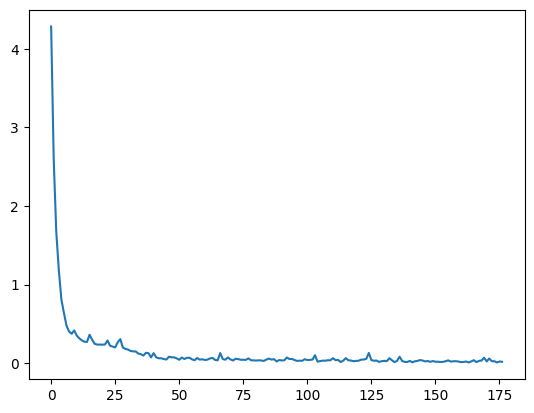

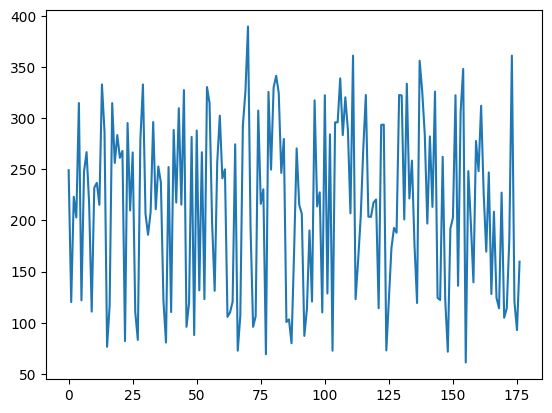

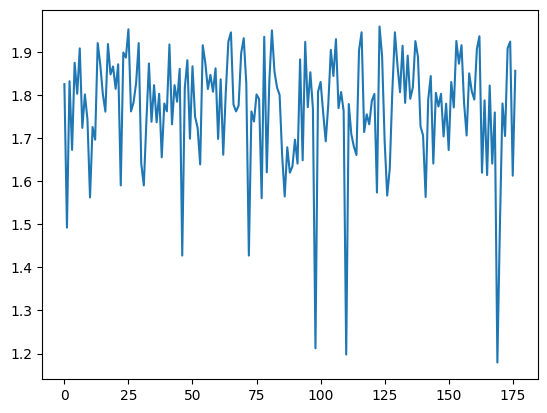

In [ ]:
plt.plot(class_losses)
plt.show()
plt.plot(bbox_losses)
plt.show()
plt.plot(giou_losses)
plt.show()

In [ ]:


detr = detr.to("cuda")
torch.set_grad_enabled(False)
detr.eval()

eval_loader = val_datalaoder

input_, (tgt_cl, tgt_bbox) = next(iter(eval_loader))[:4]

# out_cl, out_bbox = detr(input_.cuda())
out_cl, out_bbox = detr(input_.cuda())['layer_1'].values()
out_bbox = out_bbox.sigmoid().cpu()
out_cl = out_cl.cpu()

fig, axs = plt.subplots(4, 2, figsize=(10, 10), constrained_layout=True)
# [a.set_axis_off() for a in axs.ravel()]

for ix in range(4):
    o_cl = out_cl[ix]
    t_cl = tgt_cl[ix]
    o_bbox = out_bbox[ix]
    t_bbox = tgt_bbox[ix]

    o_probs = o_cl.softmax(dim=-1)
    # print(o_bbox)
    o_bbox = ops.box_convert(100*o_bbox, in_fmt='cxcywh', out_fmt='xyxy')
    t_bbox = ops.box_convert(t_bbox, in_fmt='xyxy', out_fmt='xyxy')

    im = revert_normalization(input_)[ix].permute(1,2,0).cpu().clip(0,1)

    o_keep = o_probs.argmax(-1) != 91

    axs[ix, 0].imshow(im)
    plot_im_with_boxes(im, o_bbox[o_keep], o_probs[o_keep], ax=axs[ix, 0])
    axs[ix, 1].imshow(im)
    plot_im_with_boxes(im, t_bbox, t_cl, ax=axs[ix, 1])
    # plot_im_with_boxes(im, o_bbox, o_probs, ax=axs[ix, 1])

NameError: name 'detr' is not defined

In [ ]:
out_bbox[ix]

tensor([[0.5880, 0.7450, 0.8091, 0.8154],
        [0.5996, 0.7632, 0.7899, 0.8219],
        [0.6064, 0.7807, 0.8115, 0.8033],
        [0.5254, 0.7437, 0.7763, 0.7925],
        [0.5893, 0.7433, 0.7810, 0.8013],
        [0.5372, 0.7357, 0.7769, 0.7930],
        [0.6313, 0.7892, 0.8304, 0.8354],
        [0.6790, 0.7919, 0.8437, 0.8380],
        [0.6295, 0.7878, 0.7988, 0.8312],
        [0.6579, 0.7891, 0.8492, 0.8610],
        [0.6085, 0.7804, 0.8208, 0.8383],
        [0.9889, 0.9928, 0.9934, 0.9950],
        [0.6033, 0.8018, 0.8282, 0.8311],
        [0.5611, 0.7170, 0.7890, 0.8026],
        [0.6260, 0.7590, 0.8246, 0.8392],
        [0.5866, 0.7169, 0.7802, 0.7818],
        [0.6266, 0.7902, 0.8274, 0.8203],
        [0.5901, 0.7621, 0.8088, 0.8163],
        [0.5818, 0.7444, 0.7949, 0.8073],
        [0.5869, 0.7598, 0.8059, 0.8064],
        [0.6538, 0.7861, 0.8328, 0.8433],
        [0.6135, 0.7529, 0.8133, 0.8193],
        [0.5872, 0.7540, 0.7951, 0.7784],
        [0.6097, 0.7522, 0.8095, 0

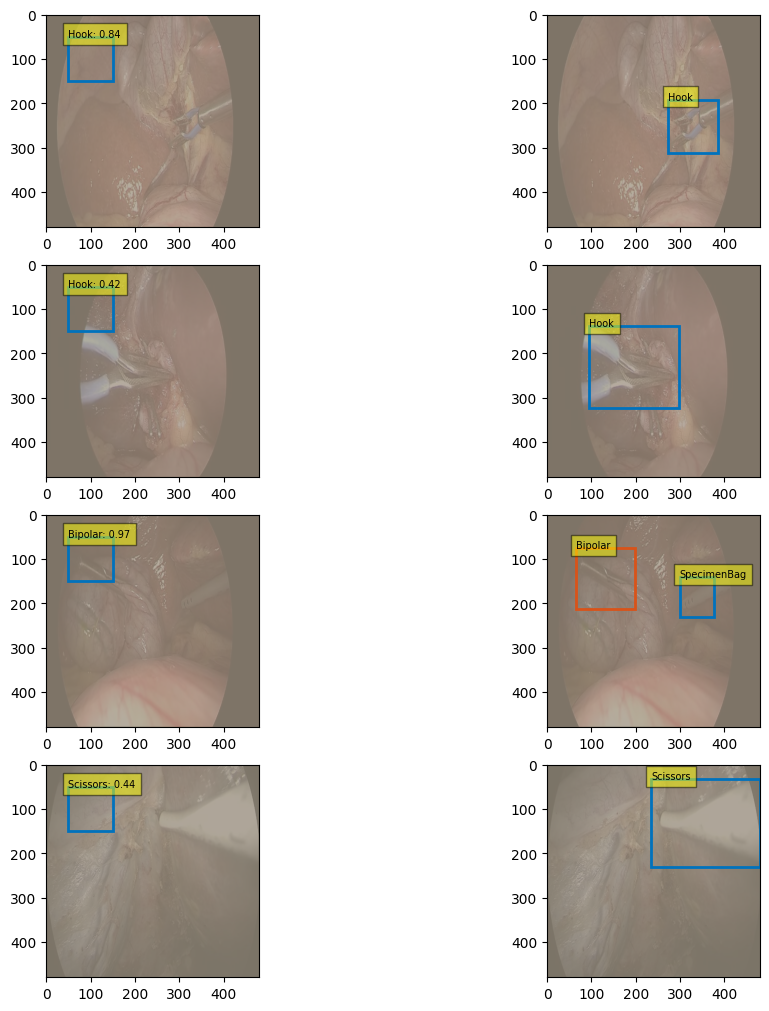

In [ ]:
detr = detr.to("cuda")
torch.set_grad_enabled(False)
detr.eval()

eval_loader = train_dataloader

input_, (tgt_cl, tgt_bbox) = next(iter(eval_loader))[:4]

# out_cl, out_bbox = detr(input_.cuda())
out_cl, out_bbox = detr(input_.cuda())['layer_1'].values()
out_bbox = out_bbox.sigmoid().cpu()
out_cl = out_cl.cpu()

fig, axs = plt.subplots(4, 2, figsize=(10, 10), constrained_layout=True)
# [a.set_axis_off() for a in axs.ravel()]

for ix in range(4):
    o_cl = out_cl[ix]
    t_cl = tgt_cl[ix]
    o_bbox = out_bbox[ix]
    t_bbox = tgt_bbox[ix]

    o_probs = o_cl.softmax(dim=-1)
    # print(o_bbox)
    o_bbox = ops.box_convert(100*o_bbox, in_fmt='cxcywh', out_fmt='xyxy')
    t_bbox = ops.box_convert(t_bbox, in_fmt='xyxy', out_fmt='xyxy')

    im = revert_normalization(input_)[ix].permute(1,2,0).cpu().clip(0,1)

    o_keep = o_probs.argmax(-1) < 8

    axs[ix, 0].imshow(im)
    plot_im_with_boxes(im, o_bbox[o_keep], o_probs[o_keep], ax=axs[ix, 0])
    axs[ix, 1].imshow(im)
    plot_im_with_boxes(im, t_bbox, t_cl, ax=axs[ix, 1])
    # plot_im_with_boxes(im, o_bbox, o_probs, ax=axs[ix, 1])

In [ ]:
# out_cl, out_bbox = detr(input_.cuda())
out_cl, out_bbox = detr(input_.cuda())['layer_5'].values()
out_bbox = out_bbox.sigmoid().cpu()
out_cl = out_cl.cpu()

fig, axs = plt.subplots(4, 2, figsize=(10, 10), constrained_layout=True)
# [a.set_axis_off() for a in axs.ravel()]

for ix in range(4):
    o_cl = out_cl[ix]
    t_cl = tgt_cl[ix]
    o_bbox = out_bbox[ix]
    t_bbox = tgt_bbox[ix]

    o_probs = o_cl.softmax(dim=-1)
    o_bbox = ops.box_convert(o_bbox*480, in_fmt='xyxy', out_fmt='xyxy')
    t_bbox = ops.box_convert(t_bbox, in_fmt='xyxy', out_fmt='xyxy')

    im = revert_normalization(input_)[ix].permute(1,2,0).cpu().clip(0,1)

    o_keep = o_probs.argmax(-1) != 91

    axs[ix, 0].imshow(im)
    plot_im_with_boxes(im, o_bbox[o_keep], o_probs[o_keep], ax=axs[ix, 0])
    axs[ix, 1].imshow(im)
    plot_im_with_boxes(im, t_bbox, t_cl, ax=axs[ix, 1])
    # plot_im_with_boxes(im, o_bbox, o_probs, ax=axs[ix, 1])

In [ ]:
y = detr(input_.cuda())

# DETR Facebook

In [ ]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False);

In [ ]:
class DETRdemo(nn.Module):
    """
    Demo DETR implementation.

    Demo implementation of DETR in minimal number of lines, with the
    following differences wrt DETR in the paper:
    * learned positional encoding (instead of sine)
    * positional encoding is passed at input (instead of attention)
    * fc bbox predictor (instead of MLP)
    The model achieves ~40 AP on COCO val5k and runs at ~28 FPS on Tesla V100.
    Only batch size 1 supported.
    """
    def __init__(self, num_classes, hidden_dim=256, nheads=8,
                 num_encoder_layers=6, num_decoder_layers=6):
        super().__init__()

        # create ResNet-50 backbone
        self.backbone = resnet50()
        del self.backbone.fc

        # create conversion layer
        self.conv = nn.Conv2d(2048, hidden_dim, 1)

        # create a default PyTorch transformer
        self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers)

        # prediction heads, one extra class for predicting non-empty slots
        # note that in baseline DETR linear_bbox layer is 3-layer MLP
        self.linear_class = nn.Linear(hidden_dim, num_classes + 1)
        self.linear_bbox = nn.Linear(hidden_dim, 4)

        # output positional encodings (object queries)
        self.query_pos = nn.Parameter(torch.rand(100, hidden_dim))

        # spatial positional encodings
        # note that in baseline DETR we use sine positional encodings
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))

    def forward(self, inputs):
        # propagate inputs through ResNet-50 up to avg-pool layer
        x = self.backbone.conv1(inputs)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        # convert from 2048 to 256 feature planes for the transformer
        h = self.conv(x)

        # construct positional encodings
        H, W = h.shape[-2:]
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

        # propagate through the transformer
        h = self.transformer(pos + 0.1 * h.flatten(2).permute(2, 0, 1),
                             self.query_pos.unsqueeze(1)).transpose(0, 1)

        # finally project transformer outputs to class labels and bounding boxes
        return {'pred_logits': self.linear_class(h),
                'pred_boxes': self.linear_bbox(h).sigmoid()}

In [ ]:
detr = DETRdemo(num_classes=91)
state_dict = torch.hub.load_state_dict_from_url(
    url='https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth',
    map_location='cpu', check_hash=True)
detr.load_state_dict(state_dict)
detr.eval();

In [ ]:
input_, targets = next(iter(test_dataloader))[:4]

In [ ]:
input_.shape

In [ ]:
detr(input_)['pred_logits']